<a href="https://colab.research.google.com/github/aljoharas/datascience/blob/main/spotifyproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data Collection

In [ ]:
!pip install spotipy


In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
#hide our api key for safety
auth_manager = SpotifyClientCredentials()
sp = spotipy.Spotify(auth_manager=auth_manager)


In [ ]:
import os
import requests


csv_urls = [
  "https://raw.githubusercontent.com/aljoharas/datascience/refs/heads/main/charts/regional-ae-weekly-2025-08-07.csv",
  "https://raw.githubusercontent.com/aljoharas/datascience/refs/heads/main/charts/regional-au-weekly-2025-08-07.csv",
  "https://raw.githubusercontent.com/aljoharas/datascience/refs/heads/main/charts/regional-br-weekly-2025-08-07.csv",
  "https://raw.githubusercontent.com/aljoharas/datascience/refs/heads/main/charts/regional-by-weekly-2025-08-07.csv",
  "https://raw.githubusercontent.com/aljoharas/datascience/refs/heads/main/charts/regional-ch-weekly-2025-08-07.csv",
  "https://raw.githubusercontent.com/aljoharas/datascience/refs/heads/main/charts/regional-eg-weekly-2025-08-07.csv",
  "https://raw.githubusercontent.com/aljoharas/datascience/refs/heads/main/charts/regional-gb-weekly-2025-08-07.csv",
  "https://raw.githubusercontent.com/aljoharas/datascience/refs/heads/main/charts/regional-global-weekly-2025-09-18.csv",
  "https://raw.githubusercontent.com/aljoharas/datascience/refs/heads/main/charts/regional-hk-weekly-2025-08-07.csv",
  "https://raw.githubusercontent.com/aljoharas/datascience/refs/heads/main/charts/regional-in-weekly-2025-08-07.csv",
  "https://raw.githubusercontent.com/aljoharas/datascience/refs/heads/main/charts/regional-it-weekly-2025-08-07.csv",
  "https://raw.githubusercontent.com/aljoharas/datascience/refs/heads/main/charts/regional-jp-weekly-2025-08-07.csv",
  "https://raw.githubusercontent.com/aljoharas/datascience/refs/heads/main/charts/regional-kr-weekly-2025-08-07.csv",
  "https://raw.githubusercontent.com/aljoharas/datascience/refs/heads/main/charts/regional-sa-weekly-2025-09-18.csv",
  "https://raw.githubusercontent.com/aljoharas/datascience/refs/heads/main/charts/regional-th-weekly-2025-08-07.csv",
  "https://raw.githubusercontent.com/aljoharas/datascience/refs/heads/main/charts/regional-tr-weekly-2025-08-07.csv",
  "https://raw.githubusercontent.com/aljoharas/datascience/refs/heads/main/charts/regional-tw-weekly-2025-08-07.csv",
  "https://raw.githubusercontent.com/aljoharas/datascience/refs/heads/main/charts/regional-us-weekly-2025-08-07.csv",
  "https://raw.githubusercontent.com/aljoharas/datascience/refs/heads/main/charts/regional-uy-weekly-2025-08-07.csv",
  "https://raw.githubusercontent.com/aljoharas/datascience/refs/heads/main/charts/regional-ve-weekly-2025-08-07.csv",
]

for url in csv_urls:
    filename = os.path.join("/content", url.split("/")[-1])
    if not os.path.exists(filename):
        r = requests.get(url)
        if r.status_code == 200:
            with open(filename, "wb") as f:
                f.write(r.content)
        else:
            print(f"Failed to download {url} — status code {r.status_code}")

import glob
chart_files = glob.glob("/content/regional-*.csv")
print(f"Found {len(chart_files)} chart files")

Found 20 chart files


In [ ]:
import time
import pandas as pd # Import pandas here
for f in chart_files:
    df = pd.read_csv(f)
    print(f"{f}: columns = {df.columns.tolist()}")

#filter out directories
chart_files = [f for f in chart_files if os.path.isfile(f)]

print(f"Found {len(chart_files)} CSV files")


dfs = [pd.read_csv(f) for f in chart_files]
all_artists = pd.concat([df['artist_names'] for df in dfs]).unique()

print(f"Total unique artists across all charts: {len(all_artists)}")

/content/regional-ae-weekly-2025-08-07.csv: columns = ['rank', 'uri', 'artist_names', 'track_name', 'source', 'peak_rank', 'previous_rank', 'weeks_on_chart', 'streams']
/content/regional-kr-weekly-2025-08-07.csv: columns = ['rank', 'uri', 'artist_names', 'track_name', 'source', 'peak_rank', 'previous_rank', 'weeks_on_chart', 'streams']
/content/regional-sa-weekly-2025-09-18.csv: columns = ['rank', 'uri', 'artist_names', 'track_name', 'source', 'peak_rank', 'previous_rank', 'weeks_on_chart', 'streams']
/content/regional-uy-weekly-2025-08-07.csv: columns = ['rank', 'uri', 'artist_names', 'track_name', 'source', 'peak_rank', 'previous_rank', 'weeks_on_chart', 'streams']
/content/regional-by-weekly-2025-08-07.csv: columns = ['rank', 'uri', 'artist_names', 'track_name', 'source', 'peak_rank', 'previous_rank', 'weeks_on_chart', 'streams']
/content/regional-hk-weekly-2025-08-07.csv: columns = ['rank', 'uri', 'artist_names', 'track_name', 'source', 'peak_rank', 'previous_rank', 'weeks_on_chart

In [ ]:
import time
from spotipy.exceptions import SpotifyException
import requests
from requests.exceptions import ReadTimeout
import pandas as pd

artist_data = []
seen_ids = set()

for artist_name in all_artists:
    try:
        result = sp.search(q=f"artist:{artist_name}", type="artist", limit=1)
        if result['artists']['items']:
            a = result['artists']['items'][0]
            # skip if no genres or already seen
            if not a['genres'] or a['id'] in seen_ids:
                continue
            artist_data.append({
                "name": a['name'],
                "id": a['id'],
                "genres": a['genres'],
                "popularity": a['popularity']
            })
            seen_ids.add(a['id'])

        time.sleep(0.5)
    except (requests.exceptions.ConnectionError, SpotifyException, ReadTimeout) as e:
        print(f"Error fetching {artist_name}: {e}. Retrying in 5 seconds...")
        time.sleep(5)
        continue

#creating the dataframe
df_artists = pd.DataFrame(artist_data)


# Check for missing values
print("Missing values per column:\n", df_artists.isnull().sum())

# Drop duplicates based on artist ID
df_artists.drop_duplicates(subset='id', inplace=True)

# Convert genres list to comma-separated string for readability
df_artists['genres_str'] = df_artists['genres'].apply(lambda x: ', '.join(x))

# Confirm datatypes
print("\nData types after cleaning:\n", df_artists.dtypes)


print(f"Final dataset: {len(df_artists)} artists with non-empty genres")
display(df_artists)
output_path = "spotify_artists_cleaned.csv"
df_artists.to_csv(output_path, index=False, encoding='utf-8-sig')
print(f"CSV file saved successfully as '{output_path}'")




Missing values per column:
 name          0
id            0
genres        0
popularity    0
dtype: int64

Data types after cleaning:
 name          object
id            object
genres        object
popularity     int64
genres_str    object
dtype: object
Final dataset: 707 artists with non-empty genres


,name,id,genres,popularity,genres_str
0,Aditya Rikhari,3ozYqVCLohfpXIhalkhM8D,"[hindi indie, indian indie, desi pop, hindi pop]",76,"hindi indie, indian indie, desi pop, hindi pop"
1,Ed Sheeran,6eUKZXaKkcviH0Ku9w2n3V,[soft pop],88,soft pop
2,Cup of Joe,61nn6nOoLWjVC1ER2qFAvN,"[opm, harana, p-pop, pinoy indie, kundiman]",75,"opm, harana, p-pop, pinoy indie, kundiman"
3,Ravyn Lenae,5RTLRtXjbXI2lSXc6jxlAz,"[alternative r&b, indie soul]",75,"alternative r&b, indie soul"
4,KATSEYE,3c0gDdb9lhnHGFtP4prQpn,[k-pop],82,k-pop
...,...,...,...,...,...
702,indigo la End,26ZBeXl5Gqr3TAv2itmyCU,"[japanese indie, j-rock, j-pop]",56,"japanese indie, j-rock, j-pop"
703,10-FEET,0QZqdhoRQkn1VphAa5eX8h,"[melodic hardcore, j-rock, j-pop]",52,"melodic hardcore, j-rock, j-pop"
704,YUZU,7lNFzeAXmSIKexINNgO6bu,"[j-pop, anime]",54,"j-pop, anime"
705,MY FIRST STORY,6cutt8thPFUICMfxaYerWd,"[j-rock, j-pop, anime]",59,"j-rock, j-pop, anime"


CSV file saved successfully as 'spotify_artists_cleaned.csv'


===== Step 1: Adding genre_count and categorizing artists =====
genre_count and genre_category added.

Sample data:


,name,id,genres,popularity,genres_str,genre_count,genre_category
0,Aditya Rikhari,3ozYqVCLohfpXIhalkhM8D,"[hindi indie, indian indie, desi pop, hindi pop]",76,"hindi indie, indian indie, desi pop, hindi pop",4,multi-genre
1,Ed Sheeran,6eUKZXaKkcviH0Ku9w2n3V,[soft pop],88,soft pop,1,single-genre
2,Cup of Joe,61nn6nOoLWjVC1ER2qFAvN,"[opm, harana, p-pop, pinoy indie, kundiman]",75,"opm, harana, p-pop, pinoy indie, kundiman",5,multi-genre
3,Ravyn Lenae,5RTLRtXjbXI2lSXc6jxlAz,"[alternative r&b, indie soul]",75,"alternative r&b, indie soul",2,multi-genre
4,KATSEYE,3c0gDdb9lhnHGFtP4prQpn,[k-pop],82,k-pop,1,single-genre


===== Step 2: Descriptive statistics by genre category =====
                count       mean        std  min    25%   50%    75%   max
genre_category                                                            
multi-genre     475.0  62.040000  12.752284  5.0  55.00  61.0  71.00  95.0
single-genre    232.0  57.961207  18.777191  0.0  44.75  61.0  72.25  95.0 

===== Descriptive Statistics =====


,popularity,genre_count
count,707.000000,707.000000
mean,60.701556,2.414427
std,15.106891,1.405963
min,0.000000,1.000000
25%,53.000000,1.000000
50%,61.000000,2.000000
75%,71.000000,3.000000
max,95.000000,8.000000


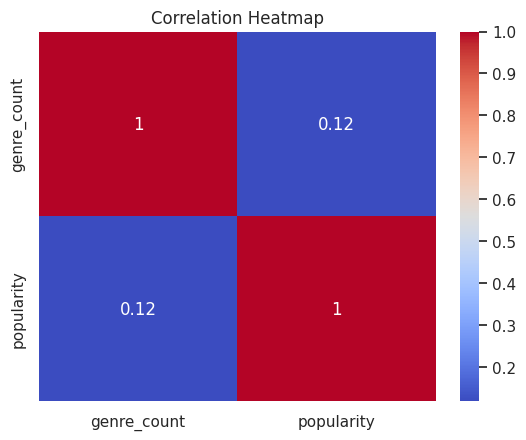

===== Step 3: Boxplot - Popularity by Genre Category =====


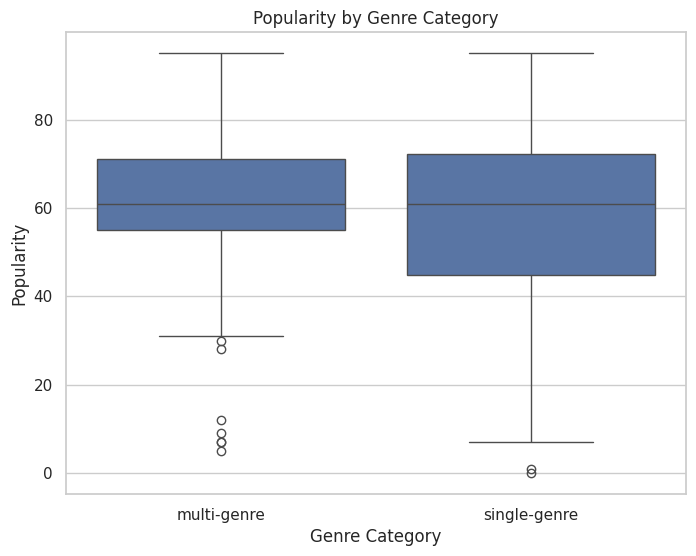

===== Step 4: Scatter plot - Popularity vs Number of Genres =====


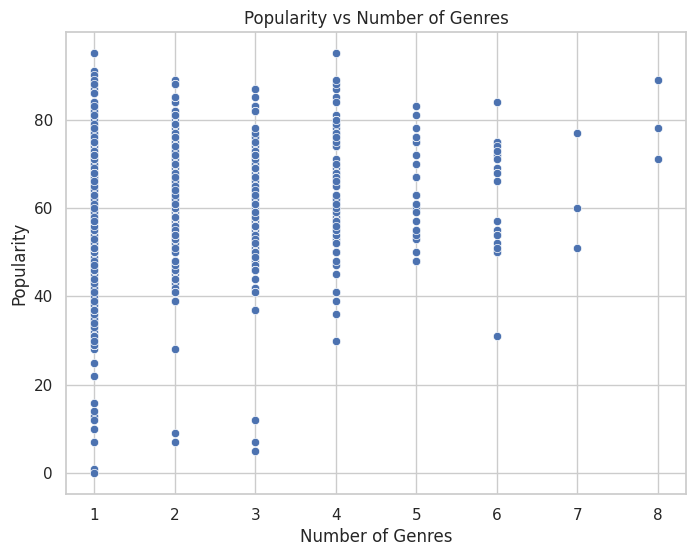

===== Step 5: Histogram of Artist Popularity =====


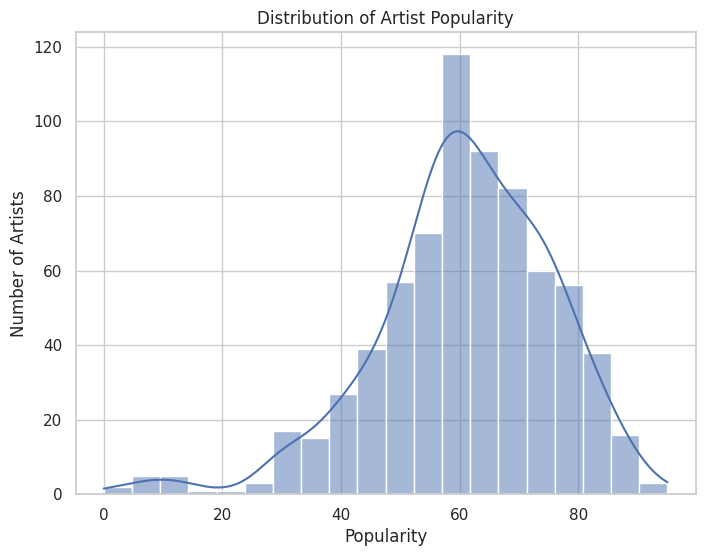

===== Step 6: Count of Single-Genre vs Multi-Genre Artists =====


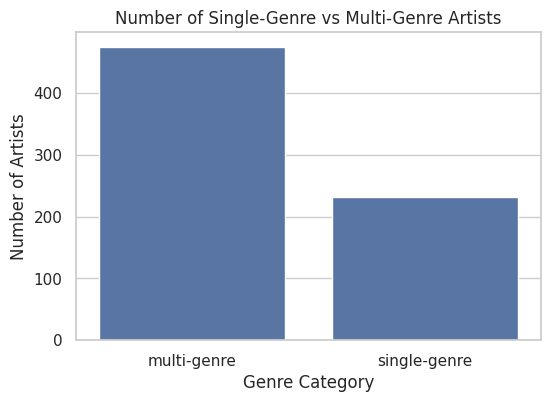

===== Step 7: Popularity vs Number of Genres (with Trend Line) =====


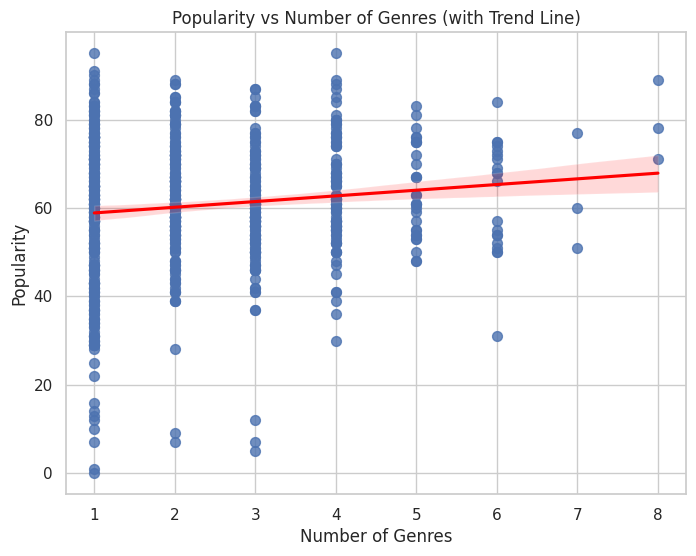

✅ All analysis and visualizations completed.


In [ ]:

# Full Analysis and Visualization


print("===== Step 1: Adding genre_count and categorizing artists =====")
df_artists['genre_count'] = df_artists['genres'].apply(len)
df_artists['genre_category'] = df_artists['genre_count'].apply(lambda x: 'single-genre' if x == 1 else 'multi-genre')
print("genre_count and genre_category added.")
print("\nSample data:")
display(df_artists.head())

#Descriptive statistics

print("===== Step 2: Descriptive statistics by genre category =====")
stats = df_artists.groupby('genre_category')['popularity'].describe()
print(stats, "\n")


# Summary Statistics

print("===== Descriptive Statistics =====")
display(df_artists.describe())


#Correlation Analysis

import seaborn as sns
import matplotlib.pyplot as plt

corr = df_artists[['genre_count', 'popularity']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()



# Step 3: Boxplot - Popularity by genre category

import matplotlib.pyplot as plt
import seaborn as sns

print("===== Step 3: Boxplot - Popularity by Genre Category =====")
plt.figure(figsize=(8,6))
sns.boxplot(x='genre_category', y='popularity', data=df_artists)
plt.title('Popularity by Genre Category')
plt.xlabel('Genre Category')
plt.ylabel('Popularity')
plt.show()


#Scatter plot - genre_count vs popularity

print("===== Step 4: Scatter plot - Popularity vs Number of Genres =====")
plt.figure(figsize=(8,6))
sns.scatterplot(x='genre_count', y='popularity', data=df_artists)
plt.title('Popularity vs Number of Genres')
plt.xlabel('Number of Genres')
plt.ylabel('Popularity')
plt.show()


#Histogram of popularity

print("===== Step 5: Histogram of Artist Popularity =====")
plt.figure(figsize=(8,6))
sns.histplot(df_artists['popularity'], bins=20, kde=True)
plt.title('Distribution of Artist Popularity')
plt.xlabel('Popularity')
plt.ylabel('Number of Artists')
plt.show()


#Countplot of genre categories
print("===== Step 6: Count of Single-Genre vs Multi-Genre Artists =====")
plt.figure(figsize=(6,4))
sns.countplot(x='genre_category', data=df_artists)
plt.title('Number of Single-Genre vs Multi-Genre Artists')
plt.xlabel('Genre Category')
plt.ylabel('Number of Artists')
plt.show()


#Scatter with regression line

print("===== Step 7: Popularity vs Number of Genres (with Trend Line) =====")
plt.figure(figsize=(8,6))
sns.regplot(x='genre_count', y='popularity', data=df_artists, scatter_kws={'s':50}, line_kws={'color':'red'})
plt.title('Popularity vs Number of Genres (with Trend Line)')
plt.xlabel('Number of Genres')
plt.ylabel('Popularity')
plt.show()

print("✅ All analysis and visualizations completed.")


The heatmap shows that the correlation coefficent is 0.12 which is a very low value confirming a weak positive linear relationship
The scatterplot shows popularity scores are widley spread and the trend line indicates a very slight positive correlation.
The boxplot compares popularity between single genre and multi genre categories. we can note that the median popularity is nearly identicial

# Secondary Data

 Loaded dataset: 1000 rows, 23 columns


,Unnamed: 0,artist_name,genres,followers,artist_popularity,artist_url,track_name,album_name,release_date,duration_ms,...,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0,Ariana Grande,pop,98934105,89,https://open.spotify.com/artist/66CXWjxzNUsdJx...,we can't be friends (wait for your love),eternal sunshine,2024-03-08,228639,...,0.646,5,-8.334,1,0.0427,0.0615,0.000030,0.0740,0.295,115.842
1,1,Ariana Grande,pop,98934105,85,https://open.spotify.com/artist/66CXWjxzNUsdJx...,the boy is mine,eternal sunshine,2024-03-08,173639,...,0.630,7,-5.854,0,0.0434,0.1570,0.000000,0.0732,0.447,97.998
2,2,Ariana Grande,pop,98934105,83,https://open.spotify.com/artist/66CXWjxzNUsdJx...,intro (end of the world),eternal sunshine,2024-03-08,92400,...,0.362,10,-9.480,1,0.0416,0.6700,0.000000,0.1760,0.385,84.726
3,3,Ariana Grande,pop,98934105,80,https://open.spotify.com/artist/66CXWjxzNUsdJx...,Save Your Tears (Remix) (with Ariana Grande) -...,After Hours (Deluxe),2020-03-20,191013,...,0.825,0,-4.645,1,0.0325,0.0215,0.000024,0.0936,0.593,118.091
4,4,Ariana Grande,pop,98934105,79,https://open.spotify.com/artist/66CXWjxzNUsdJx...,"yes, and?",eternal sunshine,2024-03-08,214994,...,0.775,1,-6.614,1,0.0548,0.1900,0.000065,0.1130,0.787,118.998


🧹 After removing duplicate artists: 118 unique artists remain.

===== Descriptive Statistics =====


,artist_popularity,genre_count
count,118.000000,118.000000
mean,58.601695,2.449153
std,32.523795,2.281840
min,0.000000,0.000000
25%,35.000000,0.000000
50%,75.000000,2.000000
75%,81.000000,4.000000
max,92.000000,9.000000


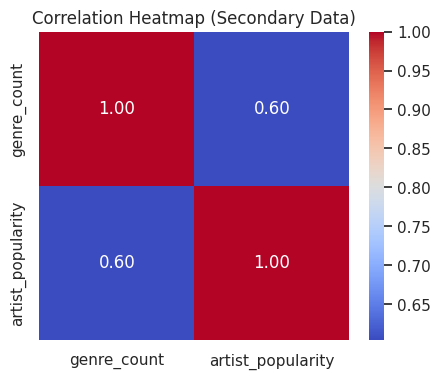

/tmp/ipython-input-3255840425.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='genre_category', y='artist_popularity', data=sec, palette='Set2')


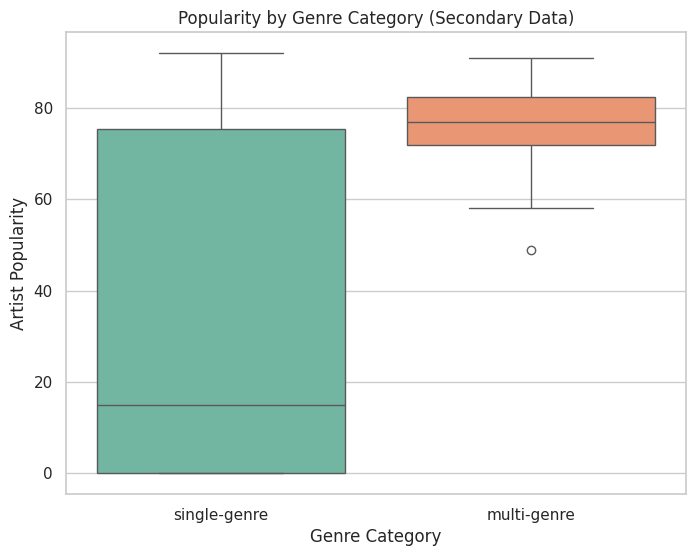

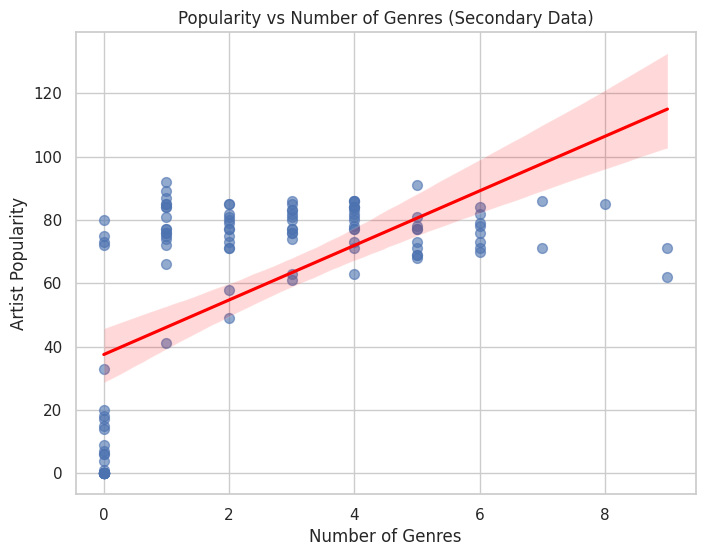

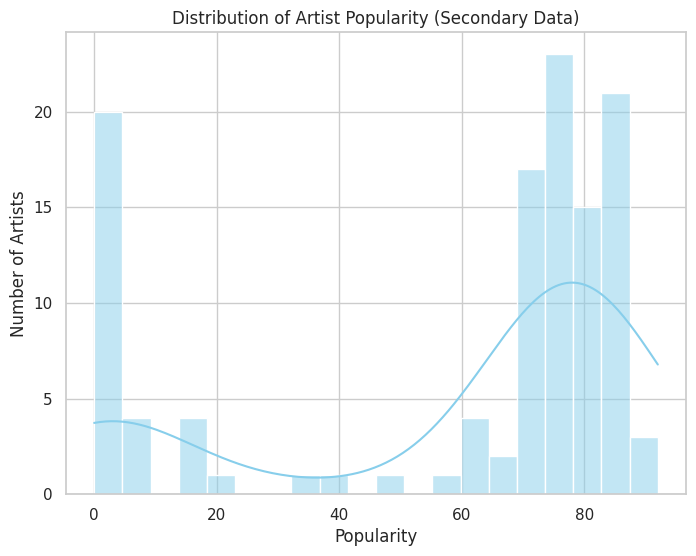

/tmp/ipython-input-3255840425.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='genre_category', data=sec, palette='pastel')


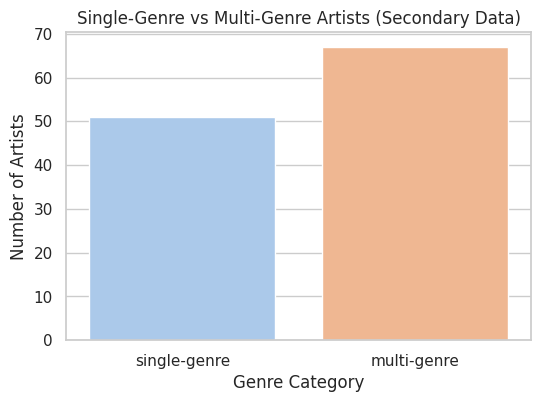

In [ ]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sec = pd.read_csv('https://raw.githubusercontent.com/aljoharas/datascience/refs/heads/main/charts/spotifydataset.csv')
print(f" Loaded dataset: {sec.shape[0]} rows, {sec.shape[1]} columns")
display(sec.head())



if 'artist_url' in sec.columns:
    sec.drop_duplicates(subset='artist_url', inplace=True)
elif 'artist_name' in sec.columns:
    sec.drop_duplicates(subset='artist_name', inplace=True)
elif 'id' in sec.columns:
    sec.drop_duplicates(subset='id', inplace=True)

print(f"🧹 After removing duplicate artists: {len(sec)} unique artists remain.")


def count_genres(entry):
    """Counts genres for list-like or comma-separated strings; returns 0 if missing/empty."""
    if entry is None or (isinstance(entry, float) and np.isnan(entry)):
        return 0
    if isinstance(entry, list):
        return len(entry)
    if isinstance(entry, str):
        parts = [g.strip() for g in entry.split(',') if g.strip()]
        return len(parts)
    return 0

# --- Feature engineering ---
sec['genre_count'] = sec['genres'].apply(count_genres)
sec['genre_category'] = sec['genre_count'].apply(lambda x: 'single-genre' if x <= 1 else 'multi-genre')


# 1) Descriptive statistics
print("\n===== Descriptive Statistics =====")
display(sec[['artist_popularity', 'genre_count']].describe())

# 2) Correlation heatmap
plt.figure(figsize=(5,4))
sns.heatmap(sec[['genre_count', 'artist_popularity']].corr(),
            annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap (Secondary Data)')
plt.show()

# 3) Boxplot: Popularity by Genre Category
plt.figure(figsize=(8,6))
sns.boxplot(x='genre_category', y='artist_popularity', data=sec, palette='Set2')
plt.title('Popularity by Genre Category (Secondary Data)')
plt.xlabel('Genre Category')
plt.ylabel('Artist Popularity')
plt.show()

# 4) Scatter + regression: Popularity vs Number of Genres
plt.figure(figsize=(8,6))
sns.regplot(x='genre_count', y='artist_popularity', data=sec,
            scatter_kws={'s':50, 'alpha':0.6}, line_kws={'color':'red'})
plt.title('Popularity vs Number of Genres (Secondary Data)')
plt.xlabel('Number of Genres')
plt.ylabel('Artist Popularity')
plt.show()

# 5) Histogram: Distribution of Popularity
plt.figure(figsize=(8,6))
sns.histplot(sec['artist_popularity'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Artist Popularity (Secondary Data)')
plt.xlabel('Popularity')
plt.ylabel('Number of Artists')
plt.show()

# 6) Countplot: Single vs Multi-Genre
plt.figure(figsize=(6,4))
sns.countplot(x='genre_category', data=sec, palette='pastel')
plt.title('Single-Genre vs Multi-Genre Artists (Secondary Data)')
plt.xlabel('Genre Category')
plt.ylabel('Number of Artists')
plt.show()



The heatmap shows a moderate positive correlation, stronger than the one in the primary dataset.
The boxplot indicates that multi genre artists seem to to achieve higher popularity while single-genre artists show wider varability.
The scatter plot displays a clear upward trend.

# Comparison

Comparison of Primary vs Secondary Dataset Metrics:


,Metric,Primary Data,Secondary Data
0,Average Popularity,60.701556,58.601695
1,Median Popularity,61.000000,75.000000
2,Std Dev Popularity,15.106891,32.523795
3,Avg Genre Count,2.414427,2.449153
4,Median Genre Count,2.000000,2.000000
5,Single-Genre %,32.814710,43.220339
6,Multi-Genre %,67.185290,56.779661
7,Num Artists,707.000000,118.000000


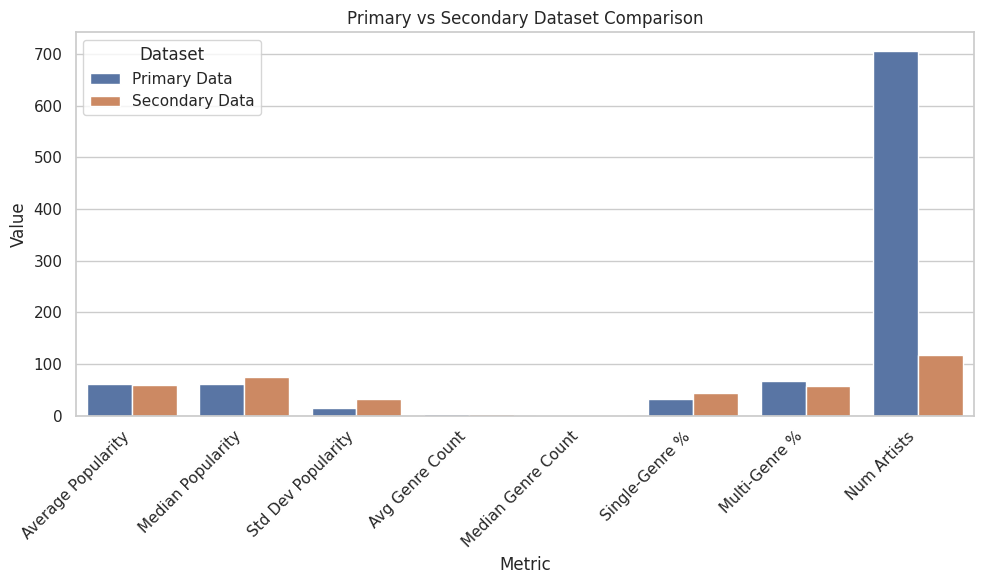

In [ ]:

# COMPARISON: Primary vs Secondary Data Metrics

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



primary = df_artists.copy()
secondary = sec.copy()

# Standardize column names
primary = primary.rename(columns={'popularity': 'artist_popularity'})
secondary = secondary.rename(columns={'artist_popularity': 'artist_popularity'})

# --- Calculate metrics for each dataset ---
primary_metrics = {
    'Average Popularity': primary['artist_popularity'].mean(),
    'Median Popularity': primary['artist_popularity'].median(),
    'Std Dev Popularity': primary['artist_popularity'].std(),
    'Avg Genre Count': primary['genre_count'].mean(),
    'Median Genre Count': primary['genre_count'].median(),
    'Single-Genre %': (primary['genre_category'].value_counts(normalize=True).get('single-genre', 0)) * 100,
    'Multi-Genre %': (primary['genre_category'].value_counts(normalize=True).get('multi-genre', 0)) * 100,
    'Num Artists': len(primary)
}

secondary_metrics = {
    'Average Popularity': secondary['artist_popularity'].mean(),
    'Median Popularity': secondary['artist_popularity'].median(),
    'Std Dev Popularity': secondary['artist_popularity'].std(),
    'Avg Genre Count': secondary['genre_count'].mean(),
    'Median Genre Count': secondary['genre_count'].median(),
    'Single-Genre %': (secondary['genre_category'].value_counts(normalize=True).get('single-genre', 0)) * 100,
    'Multi-Genre %': (secondary['genre_category'].value_counts(normalize=True).get('multi-genre', 0)) * 100,
    'Num Artists': len(secondary)
}

# --- Combine into a comparison table ---
comparison_df = pd.DataFrame({
    'Metric': list(primary_metrics.keys()),
    'Primary Data': list(primary_metrics.values()),
    'Secondary Data': list(secondary_metrics.values())
})

print("Comparison of Primary vs Secondary Dataset Metrics:")
display(comparison_df)


plt.figure(figsize=(10,6))
melted = comparison_df.melt(id_vars='Metric', var_name='Dataset', value_name='Value')
sns.barplot(data=melted, x='Metric', y='Value', hue='Dataset')
plt.xticks(rotation=45, ha='right')
plt.title('Primary vs Secondary Dataset Comparison')
plt.tight_layout()
plt.show()



This bar chart compares key metrics between the primary and secondary Spotify datasets.Both datasets show similar average and median popularity, but the secondary dataset has slightly higher variability (Std Dev) and a smaller artist pool.The primary dataset contains many more artists overall, while both datasets have a similar balance between single- and multi-genre artists, with multi-genre artists being more prevalent in both.

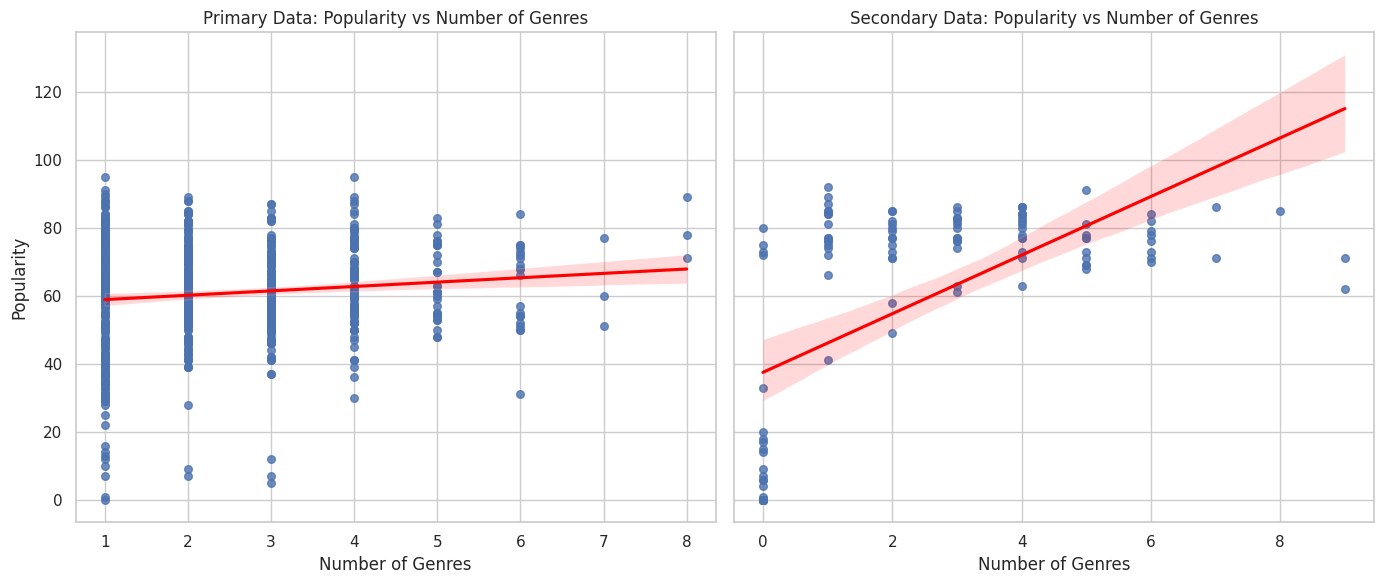

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14,6), sharey=True)

sns.regplot(x='genre_count', y='popularity', data=df_artists, ax=axes[0], scatter_kws={'s':30}, line_kws={'color':'red'})
axes[0].set_title('Primary Data: Popularity vs Number of Genres')
axes[0].set_xlabel('Number of Genres')
axes[0].set_ylabel('Popularity')

sns.regplot(x='genre_count', y='artist_popularity', data=sec, ax=axes[1], scatter_kws={'s':30}, line_kws={'color':'red'})
axes[1].set_title('Secondary Data: Popularity vs Number of Genres')
axes[1].set_xlabel('Number of Genres')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np

def count_genres(entry):
    if entry is None or (isinstance(entry, float) and np.isnan(entry)):
        return 0
    if isinstance(entry, list):
        return len(entry)
    if isinstance(entry, str):
        parts = [g.strip() for g in entry.split(',') if g.strip()]
        return len(parts)
    return 0

def ensure_genre_columns(df, pop_col, genres_col):

    out = df.copy()
    if 'artist_popularity' not in out.columns:
        out = out.rename(columns={pop_col: 'artist_popularity'})
    if 'genre_count' not in out.columns:
        out['genre_count'] = out[genres_col].apply(count_genres)
    if 'genre_category' not in out.columns:
        out['genre_category'] = out['genre_count'].apply(lambda x: 'single-genre' if x <= 1 else 'multi-genre')
    out = out.dropna(subset=['artist_popularity'])
    return out

def summarize_by_category(df):

    agg = (
        df.groupby('genre_category')['artist_popularity']
          .agg(count='count', mean='mean', std='std', median='median', min='min', max='max',
               q25=lambda x: x.quantile(0.25), q75=lambda x: x.quantile(0.75))
    )

    # rounding + formatting
    agg['count']  = agg['count'].astype(int)
    agg['mean']   = agg['mean'].round(2)
    agg['std']    = agg['std'].round(2)
    agg['median'] = agg['median'].round(1)
    agg['q25']    = agg['q25'].round(1)
    agg['q75']    = agg['q75'].round(1)
    agg['Range (Min–Max)'] = agg['min'].astype(int).astype(str) + ' – ' + agg['max'].astype(int).astype(str)

    # rename & reorder
    agg = agg.rename(columns={
        'count': 'Count',
        'mean': 'Mean Popularity',
        'std': 'Std. Deviation',
        'median': 'Median (50%)',
        'q25': '25%',
        'q75': '75%'
    })[['Count', 'Mean Popularity', 'Std. Deviation', '25%', 'Median (50%)', '75%', 'Range (Min–Max)']]

    return agg

def build_side_by_side(primary_df, secondary_df):

    p = summarize_by_category(primary_df)
    s = summarize_by_category(secondary_df)

    all_cats = sorted(set(p.index).union(set(s.index)))
    metrics = ['Count', 'Mean Popularity', 'Std. Deviation', '25%', 'Median (50%)', '75%', 'Range (Min–Max)']

    rows = []
    for cat in all_cats:
        for m in metrics:
            p_val = p.loc[cat, m] if (cat in p.index and m in p.columns) else np.nan
            s_val = s.loc[cat, m] if (cat in s.index and m in s.columns) else np.nan
            rows.append((cat, m, p_val, s_val))

    comp = pd.DataFrame(rows, columns=['Genre Category', 'Metric', 'Primary Dataset', 'Secondary Dataset'])
    return comp.set_index(['Genre Category', 'Metric'])

# ---------- Prepare inputs ----------
primary_ready   = ensure_genre_columns(df_artists, pop_col='popularity',        genres_col='genres')
secondary_ready = ensure_genre_columns(sec,        pop_col='artist_popularity', genres_col='genres')

# ---------- Compute tables ----------
primary_stats    = summarize_by_category(primary_ready)
secondary_stats  = summarize_by_category(secondary_ready)
comparison_table = build_side_by_side(primary_ready, secondary_ready)

print("Primary dataset — per-category metrics")
display(primary_stats)

print("\nSecondary dataset — per-category metrics")
display(secondary_stats)

print("\nPer-Category Metrics: Primary vs Secondary (side-by-side)")
display(comparison_table)


Primary dataset — per-category metrics


,Count,Mean Popularity,Std. Deviation,25%,Median (50%),75%,Range (Min–Max)
genre_category,,,,,,,
multi-genre,475,62.04,12.75,55.0,61.0,71.0,5 – 95
single-genre,232,57.96,18.78,44.8,61.0,72.2,0 – 95



Secondary dataset — per-category metrics


,Count,Mean Popularity,Std. Deviation,25%,Median (50%),75%,Range (Min–Max)
genre_category,,,,,,,
multi-genre,67,76.78,7.75,72.0,77.0,82.5,49 – 91
single-genre,51,34.73,37.04,0.0,15.0,75.5,0 – 92



Per-Category Metrics: Primary vs Secondary (side-by-side)


Primary Dataset Secondary Dataset
Genre Category Metric                                           
multi-genre    Count                       475                67
               Mean Popularity           62.04             76.78
               Std. Deviation            12.75              7.75
               25%                        55.0              72.0
               Median (50%)               61.0              77.0
               75%                        71.0              82.5
               Range (Min–Max)          5 – 95           49 – 91
single-genre   Count                       232                51
               Mean Popularity           57.96             34.73
               Std. Deviation            18.78             37.04
               25%                        44.8               0.0
               Median (50%)               61.0              15.0
               75%                        72.2              75.5
               Range (Min–Max)          0 – 95            0 – 92